**The dataset comes from the UCI Machine Learning repository, and it is related to direct marketing campaigns (phone calls) of a Portuguese banking institution. The classification goal is to predict whether the client will subscribe (1/0) to a term deposit (variable y).**

In [1]:
from pyspark.sql import SparkSession

In [2]:
spark = SparkSession.builder.appName('ClientSubscriptionPrediction').getOrCreate()

In [3]:
import pandas as pd

In [4]:
from pyspark.ml.regression import LinearRegression

In [5]:
url = 'https://raw.githubusercontent.com/madmashup/targeted-marketing-predictive-engine/master/banking.csv'
dataset = spark.createDataFrame(pd.read_csv(url))

In [6]:
dataset.show(5)

+---+-----------+-------+-----------------+-------+-------+----+--------+-----+-----------+--------+--------+-----+--------+-----------+------------+-----------------+-------------+------------------+-----------+---+
|age|        job|marital|        education|default|housing|loan| contact|month|day_of_week|duration|campaign|pdays|previous|   poutcome|emp_var_rate|   cons_price_idx|cons_conf_idx|         euribor3m|nr_employed|  y|
+---+-----------+-------+-----------------+-------+-------+----+--------+-----+-----------+--------+--------+-----+--------+-----------+------------+-----------------+-------------+------------------+-----------+---+
| 44|blue-collar|married|         basic.4y|unknown|    yes|  no|cellular|  aug|        thu|     210|       1|  999|       0|nonexistent|         1.4|           93.444|        -36.1|             4.963|     5228.1|  0|
| 53| technician|married|          unknown|     no|     no|  no|cellular|  nov|        fri|     138|       1|  999|       0|nonexist

In [7]:
dataset.columns

['age',
 'job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'day_of_week',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'poutcome',
 'emp_var_rate',
 'cons_price_idx',
 'cons_conf_idx',
 'euribor3m',
 'nr_employed',
 'y']

In [8]:
dataset = dataset.withColumnRenamed('y','deposit')

In [9]:
#We could see here that our independent variable having imbalance data. We need to take care about it for more precise result
dataset.groupby('deposit').count().show()

+-------+-----+
|deposit|count|
+-------+-----+
|      0|36548|
|      1| 4640|
+-------+-----+



In [10]:
numeric_list = [col[0] for col in dataset.dtypes if col[1]=='bigint']

In [11]:
numb_df = dataset.select(numeric_list).toPandas()

In [12]:
numb_df.head(5)

,age,duration,campaign,pdays,previous,deposit
0,44,210,1,999,0,0
1,53,138,1,999,0,0
2,28,339,3,6,2,1
3,39,185,2,999,0,0
4,55,137,1,3,1,1


**Correlations between independent variables.**

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline

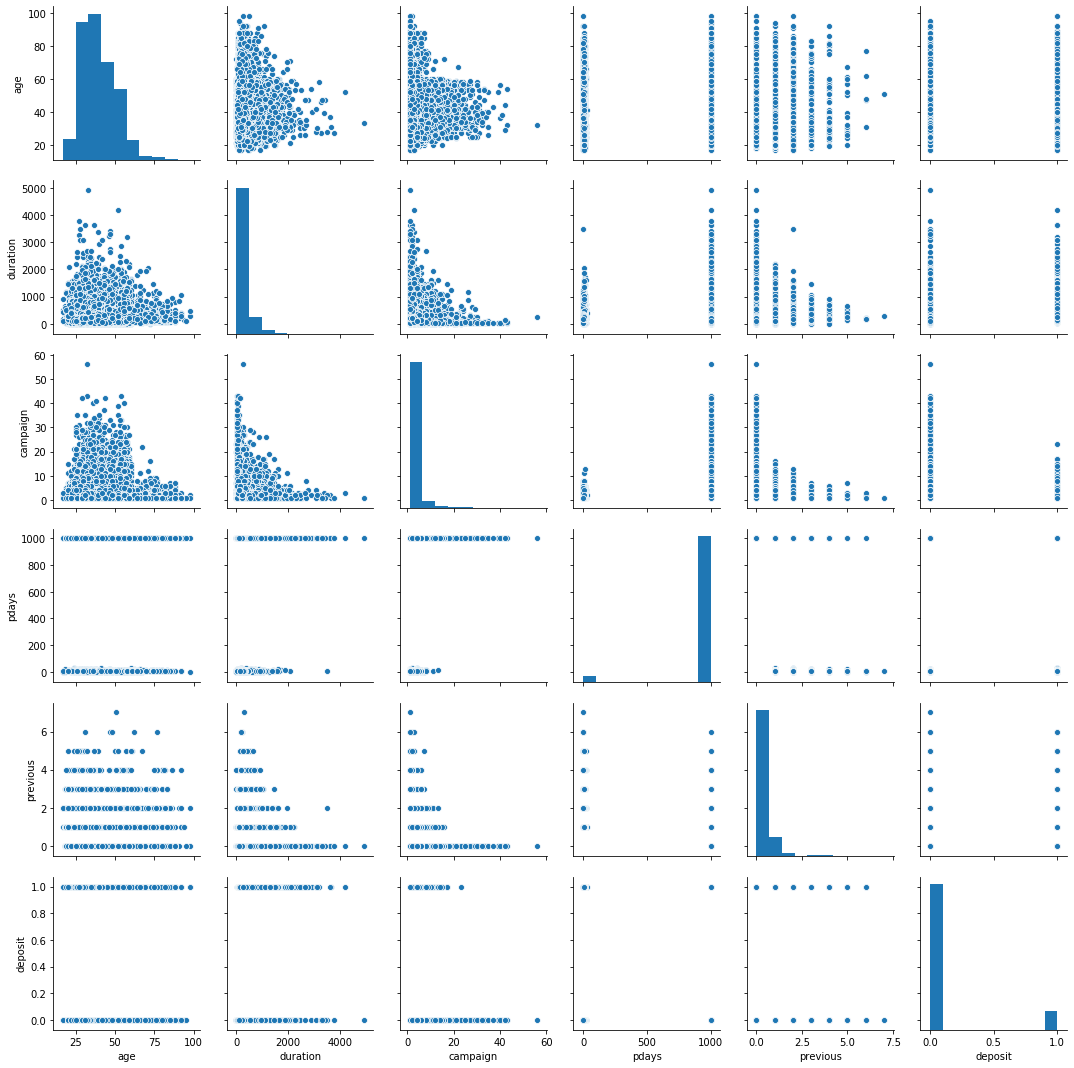

In [14]:
sns.pairplot(numb_df)

In [15]:
df = dataset.select('age', 'job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'deposit')
cols = df.columns
df.printSchema()

root
 |-- age: long (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- duration: long (nullable = true)
 |-- campaign: long (nullable = true)
 |-- pdays: long (nullable = true)
 |-- previous: long (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- deposit: long (nullable = true)



**To create Models we need to deal with categorical variables. We need to convert into numeric variable to better modeling.There are lots of technique for them. Lets demonstrate some.**

In [16]:
from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, VectorAssembler
categoricalColumns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome']
stages = []
for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    encoder = OneHotEncoderEstimator(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]
label_stringIdx = StringIndexer(inputCol = 'deposit', outputCol = 'label')
stages += [label_stringIdx]
numericCols = ['age', 'duration', 'campaign', 'pdays', 'previous']
assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

In machine learning, it is common to run a sequence of algorithms to process and learn from data. E.g., a simple text document processing workflow might include several stages:

Split each document’s text into words.
Convert each document’s words into a numerical feature vector.
Learn a prediction model using the feature vectors and labels.
MLlib represents such a workflow as a Pipeline, which consists of a sequence of PipelineStages (Transformers and Estimators) to be run in a specific order.
For more information please go through with this link
https://spark.apache.org/docs/latest/ml-pipeline.html

In [17]:
from pyspark.ml import Pipeline
pipeline = Pipeline(stages = stages)
model = pipeline.fit(df)
df = model.transform(df)
selectedCols = ['label', 'features'] + cols
df = df.select(selectedCols)
df.printSchema()

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- age: long (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- duration: long (nullable = true)
 |-- campaign: long (nullable = true)
 |-- pdays: long (nullable = true)
 |-- previous: long (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- deposit: long (nullable = true)



In [18]:
pd.DataFrame(df.take(5), columns=df.columns).transpose()

,0,1,2,3,4
label,0,0,1,0,1
features,"(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ..."
age,44,53,28,39,55
job,blue-collar,technician,management,services,retired
marital,married,married,single,married,married
education,basic.4y,unknown,university.degree,high.school,basic.4y
default,unknown,no,no,no,no
housing,yes,no,yes,no,yes
loan,no,no,no,no,no
contact,cellular,cellular,cellular,cellular,cellular


# Modling

In [19]:
train_data,test_date = df.randomSplit([0.75,0.25])

## Logistic Regression Model

In [20]:
from pyspark.ml.classification import LogisticRegression

In [21]:
lr=LogisticRegression(featuresCol='features',labelCol='label',maxIter=10)

In [22]:
lrModel = lr.fit(train_data)

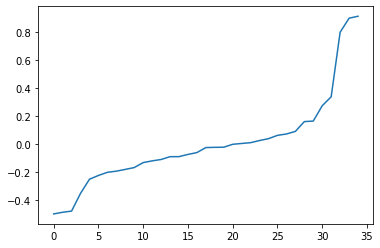

In [23]:
plt.plot(np.sort(lrModel.coefficients))

**Area Under ROC**

In [24]:
lr_summary = lrModel.summary

In [25]:
roc = lr_summary.roc.toPandas()

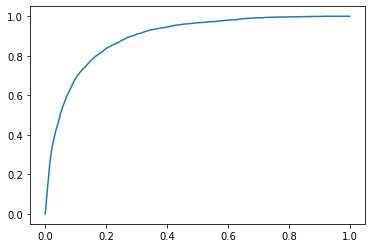

Area under Roc curve0.8948472072761872


In [27]:
plt.plot(roc['FPR'],roc['TPR'])
plt.show()
print("Area under Roc curve" + str(lr_summary.areaUnderROC))

**Precision and Recall**

In [28]:
pr = lr_summary.pr.toPandas()

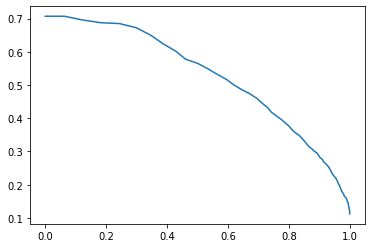

In [29]:
plt.plot(pr.recall, pr.precision)

In [30]:
prediction = lrModel.transform(test_date)

In [32]:
prediction.select('age', 'job', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

+---+------+-----+--------------------+----------+--------------------+
|age|   job|label|       rawPrediction|prediction|         probability|
+---+------+-----+--------------------+----------+--------------------+
| 28|admin.|  0.0|[2.90073006758659...|       0.0|[0.94788251497033...|
| 31|admin.|  0.0|[2.64421461480015...|       0.0|[0.93365351481936...|
| 31|admin.|  0.0|[-0.7943769842181...|       1.0|[0.31122961955505...|
| 32|admin.|  0.0|[3.20132788022842...|       0.0|[0.96088421711798...|
| 34|admin.|  0.0|[1.66012457480951...|       0.0|[0.84025472503344...|
| 35|admin.|  0.0|[3.97111526898786...|       0.0|[0.98149644051547...|
| 35|admin.|  0.0|[0.25902919923927...|       0.0|[0.56439763251613...|
| 36|admin.|  0.0|[2.55173112297025...|       0.0|[0.92768972697225...|
| 36|admin.|  0.0|[2.72361225790212...|       0.0|[0.93840565492737...|
| 37|admin.|  0.0|[2.59432876861122...|       0.0|[0.93049569578791...|
+---+------+-----+--------------------+----------+--------------

# Model Evaluation

In [34]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [37]:
evaluator = BinaryClassificationEvaluator()
evaluator.evaluate(prediction)

0.8971477787492298